In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# package

In [ ]:
import os
import math
import random
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# 預處理

### 讀檔

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/碩二上/多媒體/data/pokemon/image.zip', 'r') as zf:
  zf.extractall('/content/image')
zf.close()

#### 檢查資料

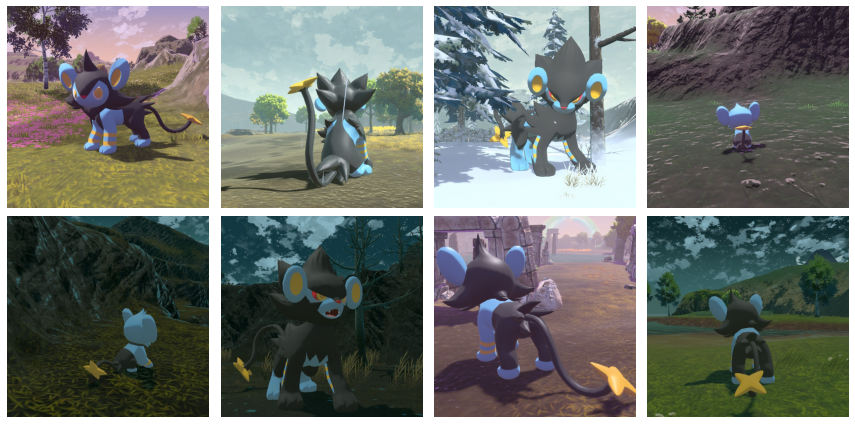

In [ ]:
%matplotlib inline
filenames = os.listdir('/content/image')
sample = random.sample(filenames, 16) 

plt.figure(figsize=(12, 6)) # 畫圖空間
for i in range(0, 8): 
  plt.subplot(2, 4, i+1) # 圖片配置 
  fname = sample[i] 
  image = load_img("/content/image/"+fname)
  plt.imshow(image)
  plt.axis('off') 
plt.tight_layout()
plt.show()

### k-fold :  train / test split

In [ ]:
from sklearn.model_selection import StratifiedKFold 
df = pd.read_csv('/content/drive/MyDrive/碩二上/多媒體/data/pokemon/image.csv')
kf = StratifiedKFold(n_splits=5)
y = df['category']

train_index_list , test_index_list = [],[]
for train_index , test_index in kf.split(df,y):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

# train_df, validate_df = train_test_split(df, test_size=0.1,stratify=df[['category']]) 

### image Generator

In [ ]:
img_width, img_height = 180, 180
target_size = (img_width, img_height) 
batch_size = 16 
x_col, y_col = 'filename', 'category' 
class_mode = 'categorical'

train_datagen = ImageDataGenerator(rescale=1./255, # 正規化
                   rotation_range=10, # 隨機旋轉
                  #  shear_range=0.2, # 錯切
                  #  zoom_range=0.2, # 放大
                  #  horizontal_flip=True, # 水平翻轉
                  #  width_shift_range=0.1, # 左右移動
                  #  height_shift_range=0.1 # 上下移動
                  )

# train_df['category'] = train_df['category'].astype(str)
# train_generator = train_datagen.flow_from_dataframe(train_df,                            
#                            "/content/image/",                    
#                            x_col=x_col, y_col=y_col,                                             
#                            class_mode=class_mode,                            
#                            target_size=target_size,                          
#                            batch_size=batch_size)

# valid_datagen = ImageDataGenerator(rescale=1./255)
# validate_df['category'] = validate_df['category'].astype(str)
# valid_generator = valid_datagen.flow_from_dataframe(validate_df,                            
#                            "/content/image/",                           
#                            x_col=x_col, y_col=y_col,                                                                                   
#                            class_mode=class_mode,                             
#                            target_size=target_size,                            
#                            batch_size=batch_size)

Found 720 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


#### 檢查 Generator 效果

Found 1 validated image filenames belonging to 1 classes.


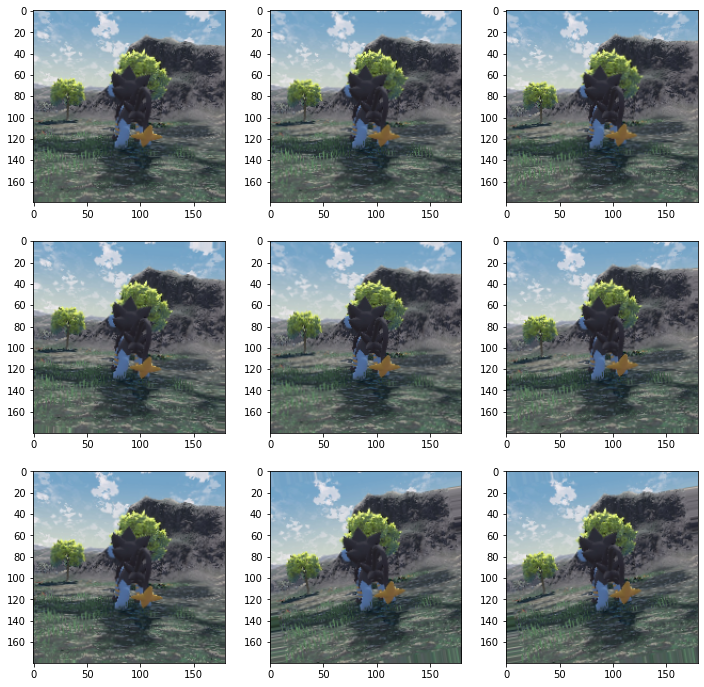

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(example_df,
                            "/content/image/",
                            x_col='filename',
                            y_col='category',
                            target_size=target_size)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
  plt.subplot(3, 3, i+1)
  for X_batch, Y_batch in example_generator:  
    image = X_batch[0]
    plt.imshow(image)
    break
plt.show()

# model

In [ ]:
def step_decay(epoch):      # epoch每增加10 學習率降一半
  initial_lrate = 0.001 
  drop = 0.5 
  epochs_drop = 10.0 
  lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)
earstop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5) 

## 64

### resnet50

In [ ]:
input_shape = (img_width, img_height, 3)
pre_trained_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
len(pre_trained_model.layers)

175

In [ ]:
model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(pre_trained_model)
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
epochs = 15 
history = model.fit(train_generator, 
           epochs=epochs, 
           steps_per_epoch=total_train//batch_size, 
           validation_data=valid_generator, 
           validation_steps=total_validate//batch_size, 
           verbose=1,
           callbacks=[lrate, earstop])

Epoch 1/15
45/45 [==============================] - 311s 7s/step - loss: 2.5467 - accuracy: 0.5597 - val_loss: 1.3098 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 303s 7s/step - loss: 0.6669 - accuracy: 0.7389 - val_loss: 1.3130 - val_accuracy: 0.3239 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 303s 7s/step - loss: 0.3990 - accuracy: 0.8319 - val_loss: 1.5560 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 301s 7s/step - loss: 0.3108 - accuracy: 0.8750 - val_loss: 1.7323 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 303s 7s/step - loss: 0.1785 - accuracy: 0.9361 - val_loss: 1.9865 - val_accuracy: 0.3352 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 304s 7s/step - loss: 0.1546 - accuracy: 0.9472 - val_loss: 2.8653 - val_accuracy: 0.3295 - lr: 0.0010


In [ ]:
model.save('resnet50.h5')

### resnet101

In [ ]:
input_shape = (img_width, img_height, 3)
pre_trained_model = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
len(pre_trained_model.layers)

171446536/171446536 [==============================] - 6s 0us/step


345

In [ ]:
model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(pre_trained_model)
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
epochs = 15 
history = model.fit(train_generator, 
           epochs=epochs, 
           steps_per_epoch=total_train//batch_size, 
           validation_data=valid_generator, 
           validation_steps=total_validate//batch_size, 
           verbose=1,
           callbacks=[lrate, earstop])

Epoch 1/15
14/45 [========>.....................] - ETA: 6:08 - loss: 4.8545 - accuracy: 0.5134

In [ ]:
model.save('resnet101.h5')

### resnet50v2

In [ ]:
input_shape = (img_width, img_height, 3)
pre_trained_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
len(pre_trained_model.layers)

In [ ]:
model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(pre_trained_model)
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
epochs = 15 
history = model.fit(train_generator, 
           epochs=epochs, 
           steps_per_epoch=total_train//batch_size, 
           validation_data=valid_generator, 
           validation_steps=total_validate//batch_size, 
           verbose=1,
           callbacks=[lrate, earstop])

## 256-128

### resnet50

In [ ]:
input_shape = (img_width, img_height, 3)
pre_trained_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(pre_trained_model)
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
for i in range(5):
    train_df , validate_df = df.loc[train_index_list[i],:] , df.loc[test_index_list[i],:]

    train_df['category'] = train_df['category'].astype(str)
    validate_df['category'] = validate_df['category'].astype(str)
    
    train_generator = train_datagen.flow_from_dataframe(train_df,                            
                               "C:/Users/User/Desktop/data/image_train/",                    
                               x_col=x_col, y_col=y_col,                                             
                               class_mode=class_mode,                            
                               target_size=target_size,                          
                               batch_size=batch_size)  
    
    valid_generator = valid_datagen.flow_from_dataframe(validate_df,                            
                               "C:/Users/User/Desktop/data/image_train/",                           
                               x_col=x_col, y_col=y_col,                                                                                   
                               class_mode=class_mode,                             
                               target_size=target_size,                            
                               batch_size=batch_size)

    epochs = 15 
    history = model.fit(train_generator, 
                        epochs=epochs, 
                        validation_data=valid_generator,  
                        verbose=1,
                        callbacks=[lrate, earstop])
    
    model.save('C:/Users/User/Desktop/data/resnet50_64_' + str(i+1) + '.h5')

### resnet101

In [ ]:
input_shape = (img_width, img_height, 3)
pre_trained_model = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(pre_trained_model)
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
for i in range(5):
    train_df , validate_df = df.loc[train_index_list[i],:] , df.loc[test_index_list[i],:]

    train_df['category'] = train_df['category'].astype(str)
    validate_df['category'] = validate_df['category'].astype(str)
    
    train_generator = train_datagen.flow_from_dataframe(train_df,                            
                               "C:/Users/User/Desktop/data/image_train/",                    
                               x_col=x_col, y_col=y_col,                                             
                               class_mode=class_mode,                            
                               target_size=target_size,                          
                               batch_size=batch_size)
    
    valid_generator = valid_datagen.flow_from_dataframe(validate_df,                            
                               "C:/Users/User/Desktop/data/image_train/",                           
                               x_col=x_col, y_col=y_col,                                                                                   
                               class_mode=class_mode,                             
                               target_size=target_size,                            
                               batch_size=batch_size)

    epochs = 15 
    history = model.fit(train_generator, 
               epochs=epochs, 
#                steps_per_epoch=total_train//batch_size, 
               validation_data=valid_generator, 
#                validation_steps=total_validate//batch_size, 
               verbose=1,
               callbacks=[lrate, earstop])
    
    model.save('C:/Users/User/Desktop/data/resnet101_' + str(i+1) + '.h5')

Found 719 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 474s 10s/step - loss: 3.2772 - accuracy: 0.6384 - val_loss: 5.5770 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 435s 10s/step - loss: 0.5533 - accuracy: 0.8915 - val_loss: 14.7281 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 436s 10s/step - loss: 0.4243 - accuracy: 0.9179 - val_loss: 4.3984 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 432s 10s/step - loss: 0.1633 - accuracy: 0.9611 - val_loss: 3.4803 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 450s 10s/step - loss: 0.2141 - accuracy: 0.9597 - val_loss: 4.8692 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 456s 10s/step - loss: 0.0961 - accuracy: 0.9764 - val_loss: 4.1674 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 420s 9s/step - lo

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 409s 9s/step - loss: 0.1205 - accuracy: 0.9861 - val_loss: 1.8438 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 410s 9s/step - loss: 0.0647 - accuracy: 0.9861 - val_loss: 0.5552 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 410s 9s/step - loss: 0.0247 - accuracy: 0.9903 - val_loss: 0.3047 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 411s 9s/step - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.1147 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 417s 9s/step - loss: 0.0416 - accuracy: 0.9930 - val_loss: 0.1190 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 418s 9s/step - loss: 0.0373 - accuracy: 0.9944 - val_loss: 0.0194 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 435s 10s/step - loss: 0.

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 441s 10s/step - loss: 0.0197 - accuracy: 0.9944 - val_loss: 1.7550e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 447s 10s/step - loss: 0.0069 - accuracy: 0.9958 - val_loss: 9.2056e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 453s 10s/step - loss: 0.0398 - accuracy: 0.9944 - val_loss: 4.6359e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 447s 10s/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 1.7881e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 434s 10s/step - loss: 0.0588 - accuracy: 0.9944 - val_loss: 1.3079e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 519s 12s/step - loss: 0.0174 - accuracy: 0.9972 - val_loss: 1.0317e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/15
45/45 [============================

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 471s 10s/step - loss: 0.0026 - accuracy: 0.9986 - val_loss: 1.4851e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 433s 10s/step - loss: 0.0399 - accuracy: 0.9917 - val_loss: 8.3175e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 448s 10s/step - loss: 0.0040 - accuracy: 0.9986 - val_loss: 3.0501e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 433s 10s/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 7.4589e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 435s 10s/step - loss: 0.0180 - accuracy: 0.9931 - val_loss: 2.8637e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 480s 11s/step - loss: 0.0049 - accuracy: 0.9958 - val_loss: 3.7960e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/15
45/45 [============================

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 516s 11s/step - loss: 0.0249 - accuracy: 0.9958 - val_loss: 3.5895e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 495s 11s/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 5.1258e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 524s 12s/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 8.9400e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 503s 11s/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 7.7611e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 522s 12s/step - loss: 0.0034 - accuracy: 0.9986 - val_loss: 8.7906e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 507s 11s/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 1.8404e-05 - val_accuracy: 1.0000 - lr: 0.0010


### resnet152

In [ ]:
input_shape = (img_width, img_height, 3)
pre_trained_model = tf.keras.applications.resnet.ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential()
input_shape = (img_width, img_height, 3)
model.add(pre_trained_model)
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
for i in range(5):
    train_df , validate_df = df.loc[train_index_list[i],:] , df.loc[test_index_list[i],:]

    train_df['category'] = train_df['category'].astype(str)
    validate_df['category'] = validate_df['category'].astype(str)
    
    train_generator = train_datagen.flow_from_dataframe(train_df,                            
                               "C:/Users/User/Desktop/data/image_train/",                    
                               x_col=x_col, y_col=y_col,                                             
                               class_mode=class_mode,                            
                               target_size=target_size,                          
                               batch_size=batch_size)

     
    valid_generator = valid_datagen.flow_from_dataframe(validate_df,                            
                               "C:/Users/User/Desktop/data/image_train/",                           
                               x_col=x_col, y_col=y_col,                                                                                   
                               class_mode=class_mode,                             
                               target_size=target_size,                            
                               batch_size=batch_size)

    epochs = 15 
    history = model.fit(train_generator, 
               epochs=epochs, 
#                steps_per_epoch=total_train//batch_size, 
               validation_data=valid_generator, 
#                validation_steps=total_validate//batch_size, 
               verbose=1,
               callbacks=[lrate, earstop])
    
    model.save('C:/Users/User/Desktop/data/resnet152_' + str(i+1) + '.h5')

Found 719 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 698s 14s/step - loss: 2.7470 - accuracy: 0.6648 - val_loss: 4.3409 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 621s 14s/step - loss: 0.6473 - accuracy: 0.8734 - val_loss: 2.4342 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 613s 14s/step - loss: 0.2343 - accuracy: 0.9444 - val_loss: 1.7889 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 646s 14s/step - loss: 0.1505 - accuracy: 0.9652 - val_loss: 1.7165 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 651s 14s/step - loss: 0.0646 - accuracy: 0.9833 - val_loss: 2.0598 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 655s 15s/step - loss: 0.0923 - accuracy: 0.9764 - val_loss: 2.5895 - val_accuracy: 0.3389 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 647s 14s/step - lo

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 619s 14s/step - loss: 0.0727 - accuracy: 0.9805 - val_loss: 3.1368 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 650s 14s/step - loss: 0.0705 - accuracy: 0.9833 - val_loss: 2.8187 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 647s 14s/step - loss: 0.0430 - accuracy: 0.9917 - val_loss: 3.4750 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 628s 14s/step - loss: 0.0744 - accuracy: 0.9875 - val_loss: 4.6802 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 588s 13s/step - loss: 0.0181 - accuracy: 0.9930 - val_loss: 4.5394 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 602s 13s/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 2.5167 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 590s 13s/step - lo

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 585s 13s/step - loss: 0.0350 - accuracy: 0.9917 - val_loss: 0.2045 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 591s 13s/step - loss: 0.0030 - accuracy: 0.9972 - val_loss: 0.2021 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 588s 13s/step - loss: 0.0487 - accuracy: 0.9917 - val_loss: 0.3275 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 587s 13s/step - loss: 0.0109 - accuracy: 0.9958 - val_loss: 0.3404 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 589s 13s/step - loss: 0.0071 - accuracy: 0.9958 - val_loss: 0.6323 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 588s 13s/step - loss: 0.0254 - accuracy: 0.9930 - val_loss: 0.7551 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 588s 13s/step - lo

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 591s 13s/step - loss: 0.0211 - accuracy: 0.9958 - val_loss: 1.0664 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 590s 13s/step - loss: 0.0465 - accuracy: 0.9931 - val_loss: 1.0559 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 588s 13s/step - loss: 0.0014 - accuracy: 0.9986 - val_loss: 0.9464 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 588s 13s/step - loss: 0.0043 - accuracy: 0.9972 - val_loss: 0.8609 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 586s 13s/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.6393 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 589s 13s/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.5872 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 600s 13s/step - lo

C:\Users\User\anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/15
45/45 [==============================] - 702s 16s/step - loss: 0.0054 - accuracy: 0.9972 - val_loss: 5.0264e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 696s 16s/step - loss: 0.0029 - accuracy: 0.9986 - val_loss: 6.4902e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 697s 15s/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 6.2916e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/15
19/45 [===========>..................] - ETA: 6:35 - loss: 0.0016 - accuracy: 1.0000